In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input

In [ ]:
# !unzip /content/.../'Lowercase Tuning'/Baseline/dataset.zip -d /content

print('unzipped')

unzipped


In [4]:
import numpy as np
import cv2
import os

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
batch_size = 32

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)


val_datagen = ImageDataGenerator(rescale=1./255) # No augmentation for validation
test_datagen = ImageDataGenerator(rescale=1./255)  # No augmentation for test


# Train
train_it = train_datagen.flow_from_directory(
    './dataset/train',
    target_size=(128, 128),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=batch_size,
    subset='training'
)


# Validation
val_it = val_datagen.flow_from_directory(
    './dataset/val',
    target_size=(128, 128),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=batch_size
)


# Test
test_it = test_datagen.flow_from_directory(
    './dataset/test',
    target_size=(128, 128),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

Found 182510 images belonging to 26 classes.
Found 22880 images belonging to 26 classes.
Found 22875 images belonging to 26 classes.


In [13]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, SpatialDropout2D

from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.regularizers import l2

model = Sequential([
    Input(shape=(128, 128, 1)),
    Conv2D(32, (3,3), activation='relu', padding='same',
          kernel_regularizer=l2(1e-4)),

    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.2),

    Conv2D(64, (3,3), activation='relu', padding='same',
          kernel_regularizer=l2(1e-4)),

    BatchNormalization(),
    SpatialDropout2D(0.3),
    MaxPooling2D((2,2)),

    Conv2D(128, (3,3), activation='relu', padding='same',
          kernel_regularizer=l2(1e-4)),

    BatchNormalization(),
    GlobalAveragePooling2D(),

    Dense(256, activation='relu', kernel_regularizer=l2(1e-4)),
    BatchNormalization(),

    Dropout(0.5),
    Dense(26, activation='softmax')
])

In [ ]:
# import callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Update callbacks
earlystop = EarlyStopping(
    monitor="val_loss",
    patience=4,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.3,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

def lr_schedule(epoch, lr):
    if epoch < 5:
        return lr * 1.5
    return lr

lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=1)


model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [15]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 128, 128, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout2d_2                  │ (None, 64, 64, 64)          │               0 │
│ (SpatialDropout2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 26)                  │           6,682 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 134,298 (524.60 KB)

 Trainable params: 133,338 (520.85 KB)

 Non-trainable params: 960 (3.75 KB)

In [16]:
import warnings
warnings.filterwarnings('ignore')

model.fit(
    train_it, validation_data=val_it,
    epochs=20,
    callbacks=[earlystop, reduce_lr]
)

Epoch 1/20
5704/5704 ━━━━━━━━━━━━━━━━━━━━ 379s 65ms/step - accuracy: 0.2971 - loss: 2.4623 - val_accuracy: 0.7289 - val_loss: 0.9012 - learning_rate: 0.0010
Epoch 2/20
5704/5704 ━━━━━━━━━━━━━━━━━━━━ 370s 65ms/step - accuracy: 0.5972 - loss: 1.3636 - val_accuracy: 0.7693 - val_loss: 0.8418 - learning_rate: 0.0010
Epoch 3/20
5704/5704 ━━━━━━━━━━━━━━━━━━━━ 368s 65ms/step - accuracy: 0.6629 - loss: 1.2025 - val_accuracy: 0.8551 - val_loss: 0.6171 - learning_rate: 0.0010
Epoch 4/20
5704/5704 ━━━━━━━━━━━━━━━━━━━━ 369s 65ms/step - accuracy: 0.6868 - loss: 1.1355 - val_accuracy: 0.8717 - val_loss: 0.5599 - learning_rate: 0.0010
Epoch 5/20
5704/5704 ━━━━━━━━━━━━━━━━━━━━ 369s 65ms/step - accuracy: 0.7013 - loss: 1.0981 - val_accuracy: 0.8711 - val_loss: 0.5645 - learning_rate: 0.0010
Epoch 6/20
5703/5704 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7126 - loss: 1.0704
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
5704/5704 ━━━━━━━━━━━━━━━━━━━━ 369s 65ms/step - ac

In [ ]:
model.save('./out/CharNet_LCv1.keras')

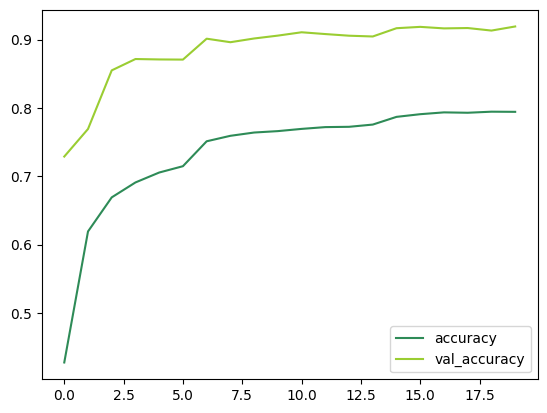

In [19]:
# plot history
import matplotlib.pyplot as plt

plt.plot(model.history.history['accuracy'], label='accuracy', color='seagreen')
plt.plot(model.history.history['val_accuracy'], label='val_accuracy', color='yellowgreen')

plt.legend()
plt.show()

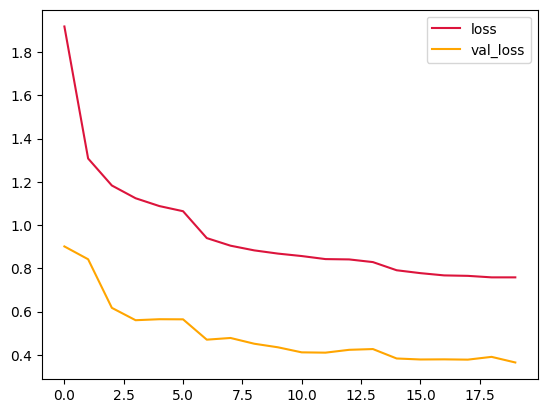

In [20]:
# plot loss

plt.plot(model.history.history['loss'], label='loss', color='crimson')
plt.plot(model.history.history['val_loss'], label='val_loss', color='orange')

plt.legend()
plt.show()


In [21]:
test_loss, test_accuracy = model.evaluate(test_it)
print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

715/715 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.8963 - loss: 0.4586
Test Accuracy: 0.8939, Test Loss: 0.4455


715/715 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step


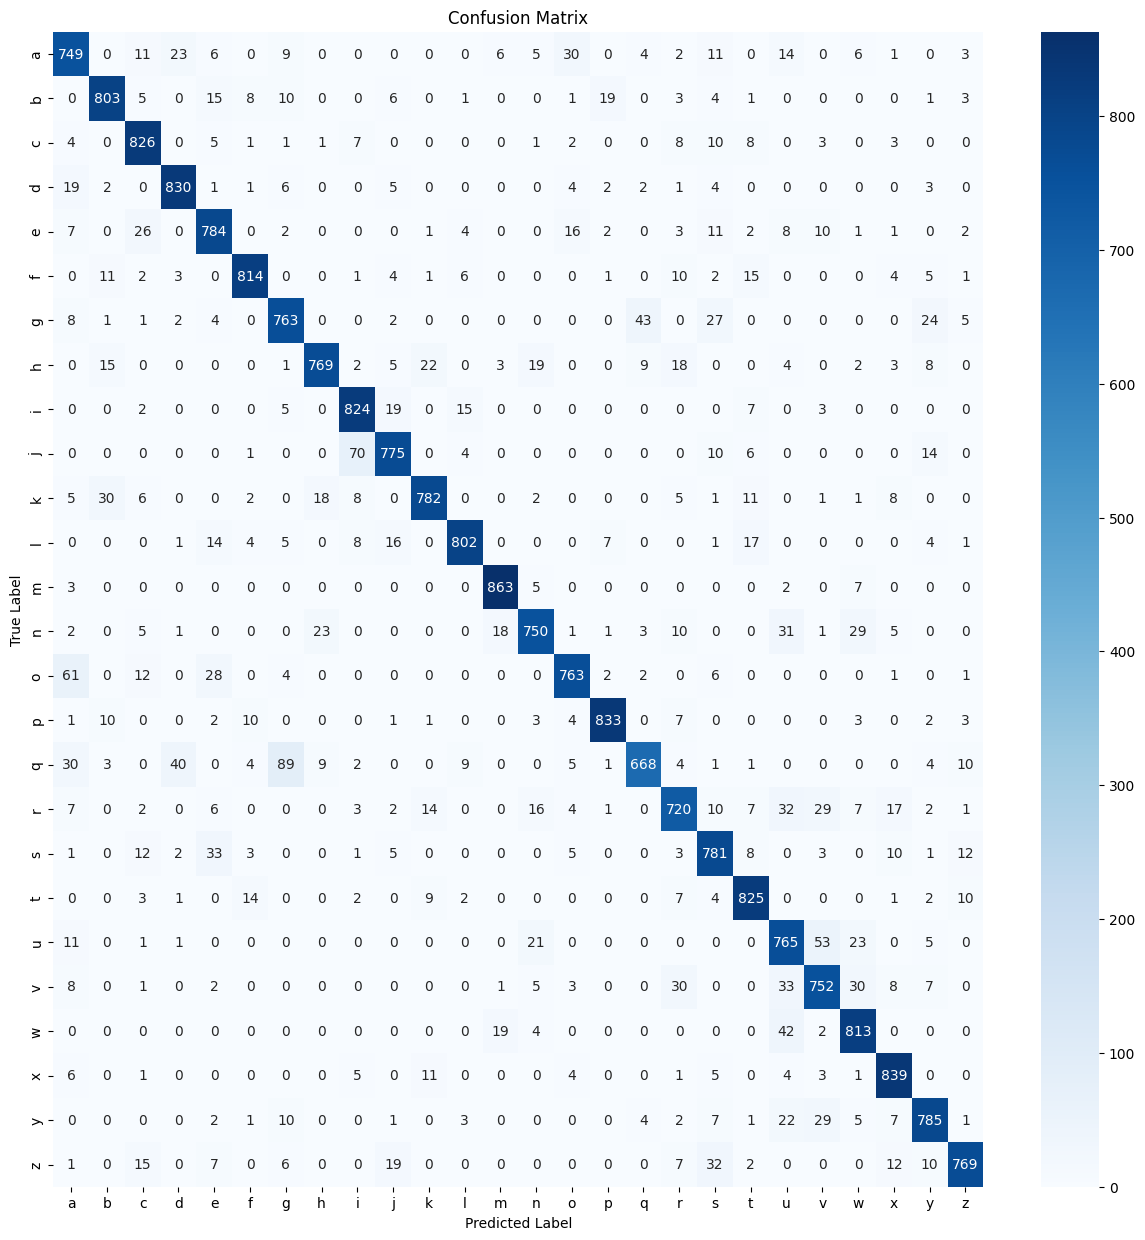


Classification Report:

              precision    recall  f1-score   support

           a       0.81      0.85      0.83       880
           b       0.92      0.91      0.92       880
           c       0.89      0.94      0.91       880
           d       0.92      0.94      0.93       880
           e       0.86      0.89      0.88       880
           f       0.94      0.93      0.93       880
           g       0.84      0.87      0.85       880
           h       0.94      0.87      0.90       880
           i       0.88      0.94      0.91       875
           j       0.90      0.88      0.89       880
           k       0.93      0.89      0.91       880
           l       0.95      0.91      0.93       880
           m       0.95      0.98      0.96       880
           n       0.90      0.85      0.88       880
           o       0.91      0.87      0.89       880
           p       0.96      0.95      0.95       880
           q       0.91      0.76      0.83       880
  

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Get true labels
true_labels = test_it.classes

# Get predicted probabilities
pred_probs = model.predict(test_it)

# Convert predicted probabilities to class labels
pred_labels = np.argmax(pred_probs, axis=1)

# Compute confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plot confusion matrix
plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_it.class_indices, yticklabels=test_it.class_indices)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Print classification report
print("\nClassification Report:\n")
print(classification_report(true_labels, pred_labels, target_names=test_it.class_indices.keys()))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


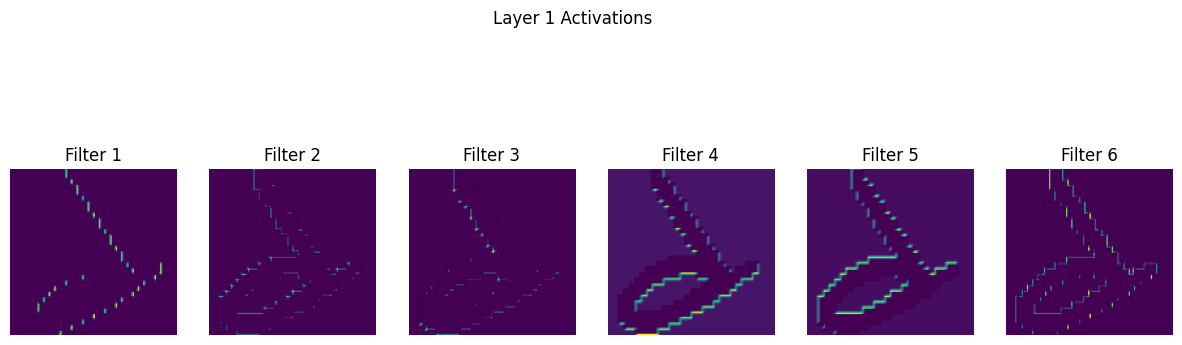

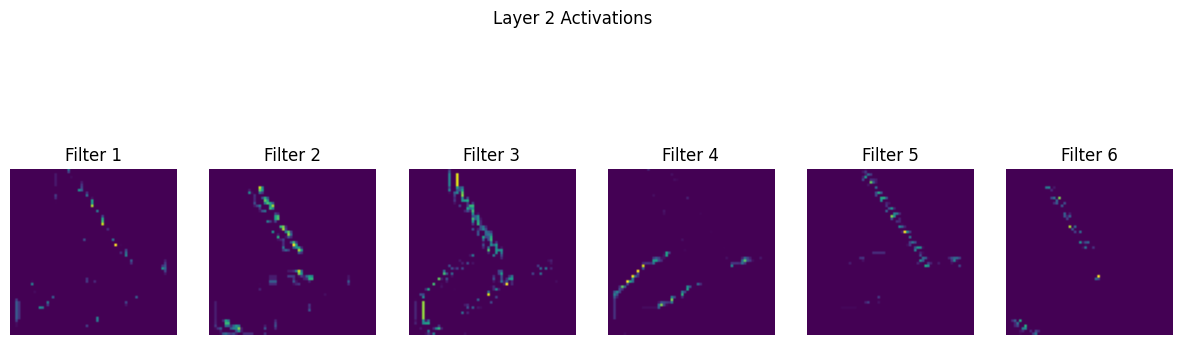

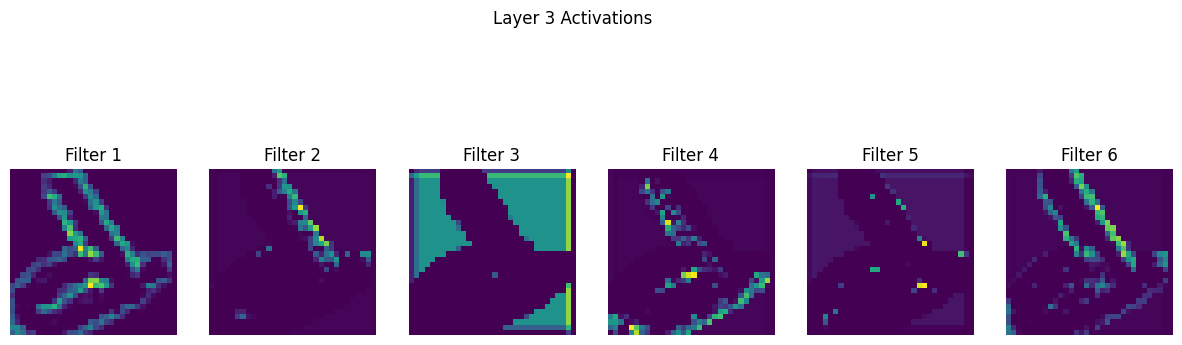

In [ ]:
from tensorflow.keras.models import Model
import numpy as np


if not model.built:
    model.build(input_shape=(None, 128, 128, 1))

# Ensure the model is built and called at least once
dummy_input = np.zeros((1, 128, 128, 1))
_ = model.predict(dummy_input)

# Extract convolutional layer outputs
layer_outputs = [layer.output for layer in model.layers if 'conv' in layer.name]
activation_model = Model(inputs=model.layers[0].input, outputs=layer_outputs)


# One test image
img = test_it[0][0][0]
img = np.expand_dims(img, axis=0)

# Get feature maps
activations = activation_model.predict(img)

for i, activation in enumerate(activations):
    num_filters = activation.shape[-1]
    fig, axes = plt.subplots(1, min(num_filters, 6), figsize=(15, 5))

    for j in range(min(num_filters, 6)):
        axes[j].imshow(activation[0, :, :, j], cmap="viridis")
        axes[j].axis("off")
        axes[j].set_title(f"Filter {j+1}")

    plt.suptitle(f"Layer {i+1} Activations")
    plt.show()